In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
%matplotlib inline
from urllib.parse import unquote
from shapely.geometry import Point, LineString, Polygon
import overpass

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

### Load Reforma GKH data

In [2]:
ref = pd.read_csv('data/export-reestrmkd-25-20190901.csv', sep=';')
ref = ref[ref["formalname_city"] == 'Владивосток'].reset_index(drop=True)

ref[['id', 'address']].head(3)

id                                            address
0  6938121  край. Приморский, г. Владивосток, Проспект. 10...
1  6938840  край. Приморский, г. Владивосток, Проспект. 10...
2  6931694  край. Приморский, г. Владивосток, Проспект. 10...

### Create Shapely Point

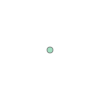

In [3]:
from shapely.geometry import Point
vladivostok = Point(131.884067, 43.118133)
vladivostok

In [4]:
type(vladivostok)

shapely.geometry.point.Point

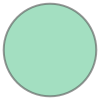

In [5]:
vladivostok.buffer(1)

### Load all hairdressers in Vladivostok using overpass

In [6]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import overpass

In [7]:
api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")
response = api.get('node["name"="Владивосток"]')

#show response 
response['features'][0]['properties']

{'addr:country': 'RU',
 'addr:postcode': '690000',
 'addr:region': 'Приморский край',
 'admin_level': '4',
 'ele': '40',
 'is_in:country': 'Russia',
 'is_in:iso_3166_2': 'RU-PRI',
 'name': 'Владивосток',
 'name:ar': 'فلاديفوستوك',
 'name:be': 'Уладзівасток',
 'name:ca': 'Vladivostok',
 'name:cs': 'Vladivostok',
 'name:da': 'Vladivostok',
 'name:de': 'Wladiwostok',
 'name:en': 'Vladivostok',
 'name:es': 'Vladivostok',
 'name:et': 'Vladivostok',
 'name:fi': 'Vladivostok',
 'name:fr': 'Vladivostok',
 'name:hi': 'व्लादिवोस्तोक',
 'name:hr': 'Vladivostok',
 'name:hu': 'Vlagyivosztok',
 'name:ja': 'ウラジオストク',
 'name:kn': 'ವ್ಲಾದಿವೋಸ್ತೊಕ',
 'name:ko': '블라디보스토크',
 'name:lt': 'Vladivostokas',
 'name:nl': 'Vladivostok',
 'name:pl': 'Władywostok',
 'name:ro': 'Vladivostok',
 'name:ru': 'Владивосток',
 'name:sk': 'Vladivostok',
 'name:sl': 'Vladivostok',
 'name:sv': 'Vladivostok',
 'name:uk': 'Владивосток',
 'name:zh': '符拉迪沃斯托克（海参崴）',
 'official_status': 'ru:город',
 'place': 'city',
 'population': 

In [8]:
response['features'][0]['geometry']

{"coordinates": [131.885577, 43.115068], "type": "Point"}

In [9]:
city_name = "Владивосток"

# Geocoding request via Nominatim
geolocator = Nominatim(user_agent="city_compare")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
geo_results = geocode(city_name, exactly_one=False, limit=3)

# Searching for relation in result set
for r in geo_results:
    print(r.address, r.raw.get("osm_type"))
    if r.raw.get("osm_type") == "relation":
        city = r
        break

# Calculating area id
area_id = int(city.raw.get("osm_id")) + 3600000000

# Excecuting overpass call
api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")
result = api.get("""
                 area(%s)->.searchArea;
                 (
                   node["shop"="hairdresser"](area.searchArea);
                 );
                 """ % area_id)

Владивосток, Владивостокский городской округ, Приморский край, Дальневосточный федеральный округ, 690000, Россия relation


### Create GeoDataFrame from overpass result

In [10]:
geom = [Point(x['geometry']['coordinates']) for x in result['features']]

barbers = gpd.GeoDataFrame(data = [x['properties'] for x in result['features']],
                           geometry = geom)

barbers[~barbers['name'].isnull()].head()

comment contact:phone description      name  name:en   name:ru  \
0     NaN           NaN         NaN   Людмила  Ludmila       NaN   
1     NaN           NaN         NaN    Вереск   Veresk    Вереск   
3     NaN           NaN         NaN    Стелла      NaN       NaN   
4     NaN           NaN         NaN  Камильфо  Kamilfo  Камильфо   
5     NaN           NaN         NaN       Фея    Fairy       NaN   

                     opening_hours phone         shop       source  \
0  Mo-Fr 8:00-19:00; Su 9:00-18:00   NaN  hairdresser          NaN   
1                              NaN   NaN  hairdresser          NaN   
3                              NaN   NaN  hairdresser  photography   
4                              NaN   NaN  hairdresser   photograph   
5                              NaN   NaN  hairdresser        image   

                     geometry  
0  POINT (131.89389 43.11432)  
1  POINT (131.88555 43.11839)  
3  POINT (131.94505 43.11237)  
4  POINT (131.92607 43.13291)  
5  POINT (131.93840 43.10607)

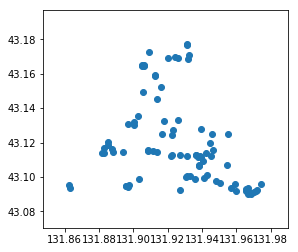

In [11]:
barbers.plot();

In [12]:
barbers.to_file('data/vladivostok_hairdressers.geojson', 'GeoJSON')

### Create GeoDataframe with target points

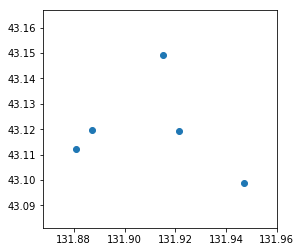

In [13]:
target_points = gpd.GeoDataFrame(geometry = [Point(x) for x in [(131.887189, 43.119502),
                                                                (131.921464, 43.119290),
                                                                (131.947048, 43.098847),
                                                                (131.915313, 43.149116),
                                                                (131.880935, 43.112050)]])
target_points['pnt_id'] = range(0, len(target_points))

target_points.plot();

### Extract coordinates from geometry column

In [14]:
barbers['lon'] = barbers.geometry.x
barbers['lat'] = barbers.geometry.y

#### Plot using geodata stored like dataframe

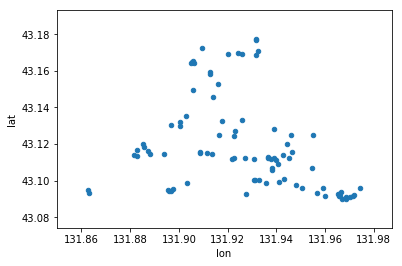

In [15]:
barbers = pd.DataFrame(barbers)

barbers.plot(x = 'lon', y = 'lat', kind = 'scatter');

### Create folium maps

In [16]:
import folium
from folium.plugins import HeatMap

#### Map with markers

In [17]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13,
               tiles='cartodbpositron')

for lat, lon in zip(barbers['lat'], barbers['lon']):
    folium.Marker(
        location=[lat, lon]).add_to(m)

m


#### Create heatmap using folium

In [18]:
barbers['lat'] = barbers['lat'].astype(float)
barbers['lon'] = barbers['lon'].astype(float)

df_for_heatmap = barbers[['lat', 'lon']]

df_for_heatmap = df_for_heatmap.dropna(axis=0, 
                                       subset=['lat','lon'])
heat_data = [[row['lat'],row['lon']] for index, row in df_for_heatmap.iterrows()]

In [19]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13, weight = 1000, height = 500,
               tiles='cartodbpositron')

HeatMap(heat_data,radius=10).add_to(m)

m

### Geocoding house data

In [20]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='test')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [21]:
location = geocode("Москва, Ленинский проспект 1")
print(location.address)
print((location.latitude, location.longitude))

Альтер Эго, 111/1, Ленинский проспект, Обручевский, Обручевский район, Юго-Западный административный округ, Москва, Центральный федеральный округ, 119421, Россия
(55.6611308, 37.5082524)


In [22]:
df = ref[ref.formalname_city == 'Владивосток'].reset_index(drop=True)

In [ ]:
for x in tqdm_notebook(range(len(df))):
    try:
        location = geocode(df.address[x])
        df.longitude[x] = location.longitude
        df.latitude[x] = location.latitude
    except AttributeError:
        print('No results')

In [25]:
df_geocoded = gpd.read_file('data/vladivostok_reformagkh.geojson')

In [26]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13, 
               weight = 1000, 
               height = 500,
               tiles='cartodbpositron')

for lat, lon in zip(df_geocoded['lat'], df_geocoded['long']):
    folium.Circle(
        location=[lat, lon],
        radius=60,
        stroke=False,
        fill=True,
        fill_color='purple',
        fill_opacity=0.4
   ).add_to(m)

m

### Estimate population using reforma gkh

In [27]:
df['population'] = df['living_quarters_count']*2.6
df['population'] = df['population'].fillna(np.mean(df['population'].dropna()))
df.head(3)

id                             region_id area_id  \
0  6938121  43909681-d6e1-432d-b61f-ddac393cb5da     NaN   
1  6938840  43909681-d6e1-432d-b61f-ddac393cb5da     NaN   
2  6931694  43909681-d6e1-432d-b61f-ddac393cb5da     NaN   

                                city_id                             street_id  \
0  7b6de6a5-86d0-4735-b11a-499081111af8  031cba93-ce6f-49cc-a792-4d32d9ec129e   
1  7b6de6a5-86d0-4735-b11a-499081111af8  031cba93-ce6f-49cc-a792-4d32d9ec129e   
2  7b6de6a5-86d0-4735-b11a-499081111af8  031cba93-ce6f-49cc-a792-4d32d9ec129e   

  shortname_region formalname_region shortname_area formalname_area  \
0             край        Приморский            NaN             NaN   
1             край        Приморский            NaN             NaN   
2             край        Приморский            NaN             NaN   

  shortname_city  ... heating_type  \
0              г  ...  Центральное   
1              г  ...  Центральное   
2              г  ...  Центральное   

                                      hot_water_type cold_water_type  \
0  Открытая с отбором сетевой воды на горячее вод...     Центральное   
1  Открытая с отбором сетевой воды на горячее вод...     Центральное   
2  Открытая с отбором сетевой воды на горячее вод...     Центральное   

  sewerage_type sewerage_cesspools_volume     gas_type     ventilation_type  \
0   Центральное                      0,00  Отсутствует  Вытяжная вентиляция   
1   Центральное                       NaN  Отсутствует         Не заполнено   
2   Центральное                      0,00  Отсутствует  Вытяжная вентиляция   

  firefighting_type         drainage_type  population  
0       Отсутствует  Внутренние водостоки  140.400000  
1      Не заполнено          Не заполнено  217.015401  
2       Отсутствует  Внутренние водостоки  226.200000  

[3 rows x 61 columns]

### Aggregate population by city grid

In [28]:
city_grid = gpd.read_file('data/grid500.geojson')
city_grid['plgn_id'] = range(0, len(city_grid))
city_grid.head(3)

left     bottom       right        top  \
0  14674000.0  5322500.0  14674500.0  5323000.0   
1  14674000.0  5323000.0  14674500.0  5323500.0   
2  14674000.0  5323500.0  14674500.0  5324000.0   

                                            geometry  plgn_id  
0  MULTIPOLYGON (((131.81878 43.06913, 131.81878 ...        0  
1  MULTIPOLYGON (((131.81878 43.07241, 131.81878 ...        1  
2  MULTIPOLYGON (((131.81878 43.07569, 131.81878 ...        2

In [29]:
df_geocoded = pd.merge(df_geocoded, df, on = 'id', how = 'inner')
len(df_geocoded)

3502

In [30]:
df_geocoded = df_geocoded[['id', 'population','geometry']]
df_geocoded.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3502 entries, 0 to 3501
Data columns (total 3 columns):
id            3502 non-null int64
population    3502 non-null float64
geometry      3502 non-null geometry
dtypes: float64(1), geometry(1), int64(1)
memory usage: 109.4 KB


In [31]:
sjoined = gpd.sjoin(df_geocoded, city_grid, how='inner')[['plgn_id', 'population']].\
              groupby('plgn_id').\
              sum().\
              reset_index()
sjoined.head()

plgn_id   population
0      214  1565.200000
1      215  1199.646204
2      244   756.600000
3      245  3853.030803
4      246  1752.061605

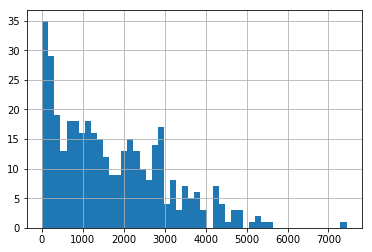

In [32]:
grid500 = pd.merge(city_grid, sjoined, on = 'plgn_id')

grid500.population.hist(bins = 50);

In [33]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13, weight = 1000, height = 500,
               tiles='cartodbpositron')
               
folium.Choropleth(
    geo_data=grid500,
    data=grid500,
    columns=['plgn_id','population'],
    key_on = 'feature.properties.plgn_id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Численность населения'
).add_to(m)

m

### Aggregate population by target area

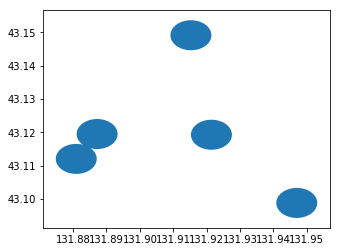

In [34]:
target_area = target_points.copy()
target_area.crs = {'init': 'epsg:4326'}
target_area = target_area.to_crs(epsg=32652)
target_area['geometry'] = target_area['geometry'].buffer(500)
target_area = target_area.to_crs(epsg=4326)
target_area.plot();

In [35]:
if target_area.crs != df_geocoded.crs:
    df_geocoded = df_geocoded.to_crs(target_area.crs)

In [36]:
sjoined_polygons = gpd.sjoin(df_geocoded, target_area)
grouped_by_data = sjoined_polygons[['pnt_id','population']].groupby('pnt_id').sum().reset_index()

target_area = pd.merge(target_area, grouped_by_data, on='pnt_id')

target_area.head()

geometry  pnt_id    population
0  POLYGON ((131.89333 43.11935, 131.89328 43.118...       0  23059.924512
1  POLYGON ((131.92760 43.11913, 131.92755 43.118...       1   5472.154013
2  POLYGON ((131.95318 43.09869, 131.95313 43.098...       2  13799.077007
3  POLYGON ((131.92145 43.14896, 131.92140 43.148...       3  20115.861605
4  POLYGON ((131.88707 43.11190, 131.88702 43.111...       4  10020.092625

In [37]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13, weight = 1000, height = 500,
               tiles='cartodbpositron')
               
folium.Choropleth(
    geo_data=target_area,
    data=target_area,
    columns=['pnt_id','population'],
    key_on = 'feature.properties.pnt_id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins=7,
    legend_name='Численность населения'
).add_to(m)

m

### Create isochrones

In [38]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from sklearn.neighbors import KDTree
from tqdm import tqdm

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

In [39]:
lon_min =  df_geocoded.geometry.x.min()
lon_max =  df_geocoded.geometry.x.max()
lat_min =  df_geocoded.geometry.y.min()
lat_max =  df_geocoded.geometry.y.max()

trip_times = [15] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [40]:
lat_max, lat_min, lon_max, lon_min

(43.282097, 42.609782, 132.093984, 131.21809)

#### Load graph using osmnx by bounds

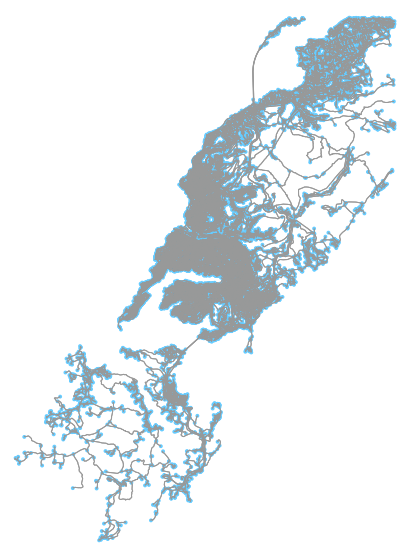

In [43]:
G_ = ox.graph_from_bbox(lat_max, lat_min, lon_max, lon_min,
                        timeout=120,
                        network_type='walk')

ox.plot_graph(G_, fig_height=10, fig_width=20);

#### Convert graph to geodataframe

In [44]:
gdf_nodes = ox.graph_to_gdfs(G_, edges=False)

tree = KDTree(gdf_nodes[['y', 'x']], metric='euclidean')

In [45]:
def make_iso_polys(G, edge_buff=0.0005, node_buff=0.0005, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, closest_node_to_target, 
                                radius=trip_time, distance='time')

        node_points = [Point((data['x'],
                              data['y'])) for node, data in subgraph.nodes(data=True)]
        
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, 
                                     geometry=node_points)
        
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr]
            t = nodes_gdf.loc[n_to]
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [46]:
isochrone_polys = []
for x in tqdm(range(len(target_points))):
    
    target_pnt = target_points['geometry'][x].y, target_points['geometry'][x].x
    
    closest_idx = tree.query([target_pnt], k=1, return_distance=False)[0]

    closest_node_to_target = gdf_nodes.iloc[closest_idx].index.values[0]
    closest_node_to_target
    
    iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
    node_colors = {}
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G_, closest_node_to_target, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color

    nc = [node_colors[node] if node in node_colors else 'none' for node in G_.nodes()]
    ns = [20 if node in node_colors else 0 for node in G_.nodes()]

    isochrone_poly = make_iso_polys(G_, infill=True)
    isochrone_polys.append(isochrone_poly)

100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


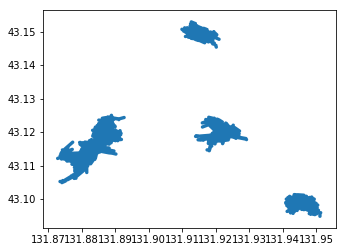

In [47]:
target_polys = target_points.copy()
target_polys['geometry'] = [x[0] for x in isochrone_polys]
target_polys.plot();

### Aggregate population by isochrones

In [48]:
if target_polys.crs != df_geocoded.crs:
    target_polys.crs = df_geocoded.crs

In [49]:
sjoined_polygons = gpd.sjoin(df_geocoded,target_polys)
grouped_by_data = sjoined_polygons[['pnt_id','population']].\
                                    groupby('pnt_id').\
                                    sum().\
                                    reset_index()

target_isochrones = pd.merge(target_polys, grouped_by_data, on='pnt_id')
target_isochrones.head()

geometry  pnt_id    population
0  POLYGON ((131.88693 43.11557, 131.88693 43.115...       0  13307.939262
1  POLYGON ((131.92972 43.11778, 131.92972 43.117...       1   6774.246421
2  POLYGON ((131.94362 43.09572, 131.94362 43.095...       2  10195.477007
3  POLYGON ((131.92071 43.14539, 131.92071 43.145...       3  10658.615401
4  POLYGON ((131.88205 43.10796, 131.88205 43.107...       4  14173.708243

In [50]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13, weight = 1000, height = 500,
               tiles='cartodbpositron')
               
folium.Choropleth(
    geo_data=target_isochrones,
    data=target_isochrones,
    columns=['pnt_id','population'],
    key_on = 'feature.properties.pnt_id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins=7,
    legend_name='Численность населения'
).add_to(m)

m

### Aggregate hairdressers by isochrones

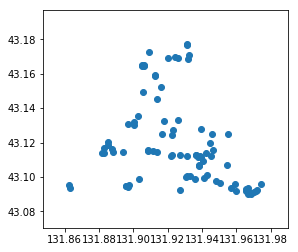

In [51]:
barbers = gpd.GeoDataFrame(barbers)
barbers.plot();

In [52]:
barbers.crs = target_polys.crs

barbers['poi_id'] = range(0, len(barbers))

In [53]:
sjoined_polygons = gpd.sjoin(barbers,target_polys, how='left')
grouped_by_data = sjoined_polygons[['pnt_id','poi_id']].\
                                    groupby('pnt_id').\
                                    count().\
                                    reset_index()

target_isochrones_poi = pd.merge(target_polys, grouped_by_data, on='pnt_id', how='left')
target_isochrones_poi['poi_id'] = target_isochrones_poi['poi_id'].fillna(0)
target_isochrones_poi.head()

geometry  pnt_id  poi_id
0  POLYGON ((131.88693 43.11557, 131.88693 43.115...       0     3.0
1  POLYGON ((131.92972 43.11778, 131.92972 43.117...       1     0.0
2  POLYGON ((131.94362 43.09572, 131.94362 43.095...       2     4.0
3  POLYGON ((131.92071 43.14539, 131.92071 43.145...       3     0.0
4  POLYGON ((131.88205 43.10796, 131.88205 43.107...       4     4.0

In [54]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13, weight = 1000, height = 500,
               tiles='cartodbpositron')
               
folium.Choropleth(
    geo_data=target_isochrones_poi,
    data=target_isochrones_poi,
    columns=['pnt_id','poi_id'],
    key_on = 'feature.properties.pnt_id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins=7,
    legend_name='Число парикмахерских в пешей доступности'
).add_to(m)

m

### Export results

In [56]:
target_isochrones.to_file('data/population_by_isochrones.geojson', 'GeoJSON')
target_isochrones_poi.to_file('data/hairdressers_by_isochrones.geojson', 'GeoJSON')
grid500.to_file('data/population_by_regular_grid.geojson', 'GeoJSON')

### Final map

In [57]:
m = folium.Map(location=[43.110745, 131.926339], 
               zoom_start=13, weight = 1000, height = 600,
               tiles='cartodbpositron')

folium.Choropleth(
    geo_data=target_isochrones_poi,
    data=target_isochrones_poi,
    columns=['pnt_id','poi_id'],
    key_on = 'feature.properties.poi_id',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins=7,
    legend_name='Число парикмахерских'
).add_to(m)

for lat, lon in zip(df_geocoded.geometry.y, df_geocoded.geometry.x):
    folium.Circle(
        location=[lat, lon],
        radius=40,
        stroke=False,
        fill=True,
        fill_color='steelblue',
        fill_opacity=0.6
   ).add_to(m)

for lat, lon in zip(barbers['lat'], barbers['lon']):
    folium.Circle(
        location=[lat, lon],
        radius=50,
        stroke=False,
        fill=True,
        fill_color='red',
        fill_opacity=0.8
   ).add_to(m)

for lat, lon in zip(target_points.geometry.y, target_points.geometry.x):
    folium.Marker(
        location=[lat, lon],
        radius=50
   ).add_to(m)
    
m

### Create map using kepler gl

In [58]:
from keplergl import KeplerGl

In [59]:
#set map config
config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 43.110745,
            'longitude': 131.926339,
            'zoom': 13
        }
    }
}

In [60]:
map_1 = KeplerGl(config = config)

map_1.add_data(data = df_geocoded, name = 'Buildings')
map_1.add_data(data = target_isochrones, name = 'Isochrones')

map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 43.110745, 'longitude': 131.926339, 'zoo…